In [17]:
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain.schema import BaseOutputParser
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
import pandas as pd
from tqdm import tqdm
import rispy
import matplotlib.pyplot as plt
import numpy as np
import asyncio
from tqdm.asyncio import tqdm_asyncio
from langchain.schema import HumanMessage

In [18]:
with open('distillersr-LI-RADS_2025_Abstract_Inclusions.ris', 'r', encoding='utf-8') as file:
    records = rispy.load(file)

df_0 = pd.DataFrame(records)

with open('distillersr-LI-RADS_2025_Abstract_Exclusions.ris', 'r', encoding='utf-8') as file:
    records = rispy.load(file)

df_1 = pd.DataFrame(records)


In [19]:
df_0.dropna(subset="abstract", inplace=True)
df_0.drop_duplicates(subset="primary_title", inplace=True)
df_0.reset_index(inplace=True, drop=True)

df_1.dropna(subset="abstract", inplace=True)
df_1.drop_duplicates(subset="primary_title", inplace=True)
df_1.reset_index(inplace=True, drop=True)

In [20]:
df_0['label'] = 'include'
df_1['label'] = 'exclude'

In [21]:
df = pd.concat([df_0, df_1], ignore_index=True)

In [22]:
df

,type_of_reference,primary_title,abstract,id,access_date,name_of_database,date,url,publication_year,first_authors,...,file_attachments1,accession_number,tertiary_title,custom1,custom7,label,custom3,publisher,edition,secondary_authors
0,JOUR,Transarterial Chemoembolization using Idarubic...,INTERVENTION: Drug : Eligible patients will be...,2837,2023/01/01/,EBM Reviews - Cochrane Central Register of Con...,2023///,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2023,NaN,...,NaN,NaN,NaN,NaN,NaN,include,NaN,NaN,NaN,NaN
1,JOUR,Interobserver Agreement of Magnetic Resonance ...,AIM: This study aimed to assess the interobser...,2119,NaN,NaN,NaN,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2020,"[Abdel Razek, Ahmed Abdel Khalek, El-Serougy, ...",...,NaN,NaN,NaN,NaN,NaN,include,NaN,NaN,NaN,NaN
2,JOUR,"The role of functional imaging; DWI, ADC and 1...",Background: The transcatheter arterial chemoem...,1946,NaN,NaN,NaN,https://ejrnm.springeropen.com/ http://ovidsp....,2021,"[Abdelrahman, Ahmed S., Abdel-Rahman, Amgad S....",...,NaN,NaN,NaN,NaN,NaN,include,NaN,NaN,NaN,NaN
3,JOUR,Interrater reliability and agreement of the li...,Purpose: The liver imaging reporting and data ...,2577,20220613//,NaN,NaN,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2022,"[Abdelrahman, Ahmed S., Madkour, Sherihan S., ...",...,NaN,NaN,NaN,NaN,NaN,include,NaN,NaN,NaN,NaN
4,JOUR,Intraindividual comparison of LI-RADS category...,Purpose: To perform an intraindividual compari...,2575,NaN,NaN,NaN,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2022,"[Agnello, F., Cannella, R., Vernuccio, F., Mid...",...,NaN,NaN,NaN,NaN,NaN,include,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,JOUR,Differentiation of high-grade glioma and prima...,OBJECTIVES: To investigate the value of the 18...,2304,20220307//,NaN,NaN,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2022,"[Zhang, Shu, Wang, Jie, Wang, Kai, Li, Xiaoton...",...,NaN,NaN,NaN,NaN,NaN,exclude,NaN,NaN,NaN,NaN
1063,JOUR,Accuracy of Various Forms of Contrast-Enhanced...,Background: Contrast-enhanced MRI can be used ...,2581,NaN,NaN,NaN,http://www.frontiersin.org/Oncology/about http...,2021,"[Zhao, C., Dai, H., Shao, J., He, Q., Su, W., ...",...,NaN,NaN,NaN,NaN,NaN,exclude,NaN,NaN,NaN,NaN
1064,JOUR,Risk Stratification and Distribution of Hepato...,Background: CEUS LI-RADS and CT/MRI LI-RADS ha...,2298,20220329//,NaN,NaN,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2022,"[Zhou, Yan, Qin, Zhengyi, Ding, Jianmin, Zhao,...",...,NaN,NaN,NaN,NaN,NaN,exclude,NaN,NaN,NaN,NaN
1065,JOUR,Prediction of Microvascular Invasion in Solita...,RATIONALE AND OBJECTIVES: AFP-negative hepatoc...,2645,NaN,Ovid MEDLINE(R),2023///,http://ovidsp.ovid.com/ovidweb.cgi?T=JS&PAGE=r...,2023,"[Zhu, Yongjian, Feng, Bing, Cai, Wei, Wang, Bi...",...,files/551/Zhu et al. - 2023 - Prediction of Mi...,NaN,NaN,NaN,NaN,exclude,NaN,NaN,NaN,NaN


In [23]:
# df.to_csv("LI-RADS_PICOS.csv", index=False)

In [24]:
import os
from dotenv import load_dotenv, dotenv_values 

load_dotenv('.env', override=True) 

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [25]:
class PITResult(BaseModel):
    Population: bool = Field(..., description="Does the study explicitly describe the population, including demographics and clinical characteristics?")
    Population_Reason: str = Field(..., description="Reason for inclusion/exclusion based on population details.")
    
    Index_Test: bool = Field(..., description="Does the study clearly define and describe the diagnostic test(s), including methodology and thresholds?")
    Index_Test_Reason: str = Field(..., description="Reason for inclusion/exclusion based on index test details.")
    
    Target_Condition: bool = Field(..., description="Does the study specify the target condition, including sub-conditions and severity stages?")
    Target_Condition_Reason: str = Field(..., description="Reason for inclusion/exclusion based on target condition details.")
    
    Qualification: str = Field(..., description="Classification of the paper: 'Qualified' or 'Not Qualified'.")
    Qualification_Reason: str = Field(..., description="Explicit reasoning for classification, indicating which elements (P, I, or T) were sufficiently defined or inadequately addressed.")


In [26]:
pit_parser = PydanticOutputParser(pydantic_object=PITResult)

In [27]:
llm = ChatOpenAI(model='gpt-4o', temperature=0, api_key=OPENAI_API_KEY)

In [28]:
pit_prompt_template = PromptTemplate(
    input_variables=["description"],
    template=(
        "You are provided with a scholarly paper about diagnostic test accuracy. "
        "Your task is to perform a detailed assessment to determine whether the paper appropriately defines and clearly presents "
        "the essential PIT elements: Population (P), Index test(s) (I), and Target condition (T).\n\n"
        "Follow these steps and reason explicitly through each step using Chain of Thought:\n\n"
        "Population (P):\n"
        "Assess whether the paper explicitly describes the individuals (or groups) being studied, including healthcare settings, demographics (age, sex), "
        "clinical characteristics (symptomatic, asymptomatic), and any prior tests conducted.\n\n"
        "Index Test(s) (I):\n"
        "Evaluate whether the paper explicitly identifies and adequately describes the diagnostic test(s) being evaluated. Include in your reasoning "
        "whether sufficient details about test methodologies, procedures, thresholds for positivity, and relevant variations are provided.\n\n"
        "Target Condition (T):\n"
        "Determine if the paper clearly specifies the condition or disease the index test aims to detect, including any sub-conditions, severity stages, "
        "or related characteristics that define the presence or absence of the condition.\n\n"
        "Based on your assessment, classify the paper into one of these two categories:\n"
        "- 'Qualified' (PIT clearly defined): The paper explicitly defines and describes Population, Index test(s), and Target condition, ensuring "
        "the study can reliably inform clinically relevant decisions.\n"
        "- 'Not Qualified' (PIT insufficiently defined): The paper lacks clarity or adequate detail in defining one or more PIT elements, significantly "
        "limiting the ability to assess the validity and clinical relevance of the test accuracy results.\n\n"
        "Finally, provide a concise yet explicit reason for your classification, clearly indicating which elements (P, I, or T) were sufficiently defined "
        "or inadequately addressed.\n\n"
        "Study Description: {description}\n\n"
        "Return a structured JSON object with the following fields:\n"
        "- 'Population' (boolean) indicating if the study sufficiently defines the population.\n"
        "- 'Population_Reason' (string) explaining why it was included/excluded.\n"
        "- 'Index_Test' (boolean) indicating if the diagnostic test is well-defined.\n"
        "- 'Index_Test_Reason' (string) explaining why it was included/excluded.\n"
        "- 'Target_Condition' (boolean) indicating if the target condition is clearly defined.\n"
        "- 'Target_Condition_Reason' (string) explaining why it was included/excluded.\n"
        "- 'Qualification' (string) indicating if the paper is 'Qualified' or 'Not Qualified'.\n"
        "- 'Qualification_Reason' (string) explicitly explaining the classification."
    )
)

In [29]:
pit_chain = pit_prompt_template | llm | pit_parser

In [30]:
study_data = df['primary_title'] + '\n ' + df['abstract']

In [36]:
# Define async invocation using the LangChain pipeline
async def async_invoke(description):
    """ Asynchronous call to LangChain's pipeline. """
    return await pit_chain.ainvoke({"description": description})

# Process studies asynchronously with batching
async def process_all_studies_async(study_data, batch_size=10):
    results = []
    for i in tqdm_asyncio(range(0, len(study_data), batch_size)):
        batch = study_data[i : i + batch_size]
        tasks = [async_invoke(desc) for desc in batch]
        responses = await asyncio.gather(*tasks)

        for desc, response in zip(batch, responses):
            results.append({
                "Study Title & Abstract": desc,
                "Population": response.Population,
                "Population Reason": response.Population_Reason,
                "Index Test": response.Index_Test,
                "Index Test Reason": response.Index_Test_Reason,
                "Target Condition": response.Target_Condition,
                "Target Condition Reason": response.Target_Condition_Reason,
                "Qualification": response.Qualification,
                "Qualification Reason": response.Qualification_Reason,
            })
    
    return results

In [37]:
import nest_asyncio
nest_asyncio.apply()

# Run optimized batch processing in a running event loop
async def main():
    return await process_all_studies_async(study_data, batch_size=10)

results = asyncio.create_task(main())  # Use create_task instead of asyncio.run()


100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [28:41<00:00, 16.09s/it]


In [ ]:
# results = []
# for desc in tqdm(study_data):
#     response = pit_chain.invoke({"description": desc})
#     results.append({
#         "Study Title & Abstract": desc,
#         "Population": response.Population,
#         "Population Reason": response.Population_Reason,
#         "Index Test": response.Index_Test,
#         "Index Test Reason": response.Index_Test_Reason,
#         "Target Condition": response.Target_Condition,
#         "Target Condition Reason": response.Target_Condition_Reason,
#         "Qualification": response.Qualification,
#         "Qualification Reason": response.Qualification_Reason,
#     })

 63%|████████████████████████████████████████████████▋                            | 675/1067 [1:00:23<30:48,  4.71s/it]

In [50]:
df_results = pd.DataFrame(results.result())
df_results['Title'] = df['primary_title']
df_results = df_results.set_index('Title').reset_index()
df_results

,Title,Study Title & Abstract,Population,Population Reason,Index Test,Index Test Reason,Target Condition,Target Condition Reason,Qualification,Qualification Reason
0,Transarterial Chemoembolization using Idarubic...,Transarterial Chemoembolization using Idarubic...,True,The study clearly defines the population as pa...,False,The study does not focus on a diagnostic test ...,True,"The target condition, hepatocellular carcinoma...",Not Qualified,The paper is classified as 'Not Qualified' bec...
1,Interobserver Agreement of Magnetic Resonance ...,Interobserver Agreement of Magnetic Resonance ...,True,The study clearly defines the population as 11...,True,The index test is well-defined as magnetic res...,True,The target condition is clearly defined as hep...,Qualified,The paper is classified as 'Qualified' because...
2,"The role of functional imaging; DWI, ADC and 1...","The role of functional imaging; DWI, ADC and 1...",False,The study does not provide explicit details ab...,True,The paper adequately describes the index tests...,True,"The target condition, residual viable HCC post...",Not Qualified,The paper is classified as 'Not Qualified' bec...
3,Interrater reliability and agreement of the li...,Interrater reliability and agreement of the li...,False,The study mentions 49 patients with 69 hepatic...,True,The study clearly identifies and describes the...,False,The study does not explicitly define the targe...,Not Qualified,The paper is classified as 'Not Qualified' bec...
4,Intraindividual comparison of LI-RADS category...,Intraindividual comparison of LI-RADS category...,True,The study clearly defines the population as ad...,True,The index tests are well-defined as contrast-e...,True,The target condition is clearly specified as h...,Qualified,The paper is classified as 'Qualified' because...
...,...,...,...,...,...,...,...,...,...,...
1062,Differentiation of high-grade glioma and prima...,Differentiation of high-grade glioma and prima...,True,The study clearly defines the population by sp...,True,The index test is well-defined as the multipar...,True,The target conditions are clearly specified as...,Qualified,The paper is classified as 'Qualified' because...
1063,Accuracy of Various Forms of Contrast-Enhanced...,Accuracy of Various Forms of Contrast-Enhanced...,False,The study does not provide specific details ab...,True,The paper adequately describes the index tests...,True,"The target condition, hepatocellular carcinoma...",Not Qualified,The paper is classified as 'Not Qualified' bec...
1064,Risk Stratification and Distribution of Hepato...,Risk Stratification and Distribution of Hepato...,False,The study does not provide explicit details ab...,True,The paper clearly identifies and describes the...,True,"The target condition, hepatocellular carcinoma...",Not Qualified,The paper is classified as 'Not Qualified' bec...
1065,Prediction of Microvascular Invasion in Solita...,Prediction of Microvascular Invasion in Solita...,True,The study clearly defines the population as 10...,True,The index test is well-defined as the dual-lay...,True,The target condition is clearly specified as m...,Qualified,The paper is classified as 'Qualified' because...


In [51]:
df_results.to_excel("pit_compliance_results.xlsx", index=False)

C:\Users\pouri\anaconda3\envs\langchain_new_env\Lib\site-packages\openpyxl\cell\cell.py:164: RuntimeWarning: coroutine 'process_all_studies_async' was never awaited
  if next(ILLEGAL_CHARACTERS_RE.finditer(value), None):


In [52]:
df_results = pd.read_excel("pit_compliance_results.xlsx")

# Graph

In [54]:
temp = df['keywords'].dropna().reset_index(drop=True)
temp = temp.apply(lambda x: x[0].split(','))

C:\Users\pouri\anaconda3\envs\langchain_new_env\Lib\site-packages\networkx\utils\backends.py:541: RuntimeWarning: networkx backend defined more than once: nx_loopback
  backends = _get_backends("networkx.backends")


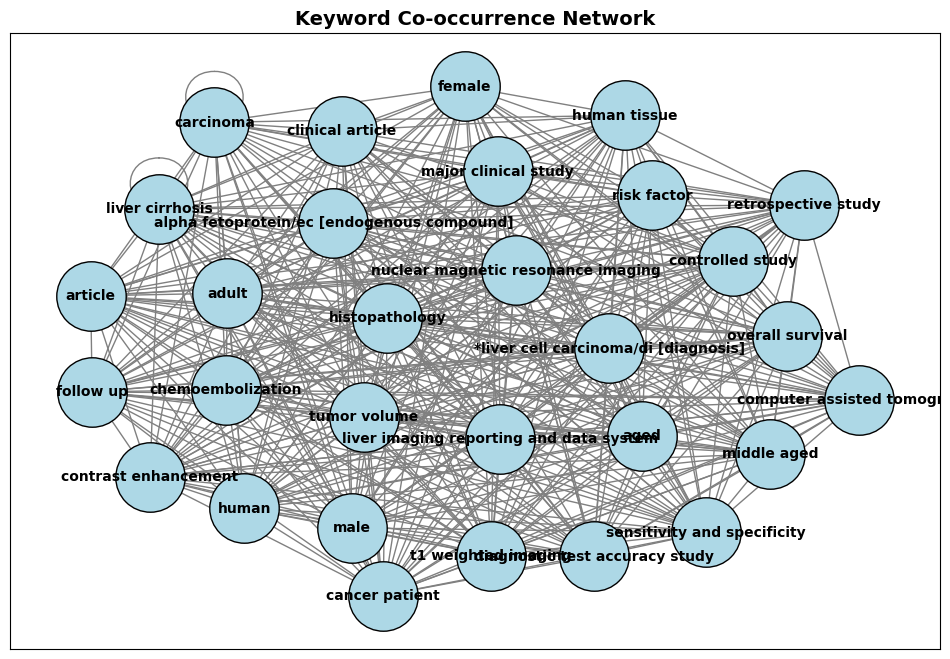

In [55]:
import networkx as nx

# Create keyword co-occurrence network
co_occurrence_graph = nx.Graph()

# Process keywords to create edges
for keyword_list in temp:
    keyword_list = [kw.strip().lower() for kw in keyword_list if kw]
    for i, keyword1 in enumerate(keyword_list):
        for j in range(i + 1, len(keyword_list)):  # Ensure only unique pairs are created
            keyword2 = keyword_list[j]
            if co_occurrence_graph.has_edge(keyword1, keyword2):
#                 co_occurrence_graph[keyword1][keyword2]['weight'] += 1
                pass
            else:
                co_occurrence_graph.add_edge(keyword1, keyword2)#, weight=1)

# Select top 30 most connected nodes (keywords)
top_keywords = sorted(co_occurrence_graph.degree, key=lambda x: x[1], reverse=True)[:30]
top_nodes = [node for node, _ in top_keywords]

# Create subgraph with only top connected nodes
subgraph = co_occurrence_graph.subgraph(top_nodes)

# Visualizing the co-occurrence network with improved aesthetics
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Positioning for better layout

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=2500, node_color="lightblue", edgecolors="black")

# Draw edges with varying thickness based on weight
edges = nx.draw_networkx_edges(subgraph, pos, edge_color="gray")#, width=[d['weight'] / 2 for (u, v, d) in subgraph.edges(data=True)])

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight="bold", font_color="black")

# Title and styling
plt.title("Keyword Co-occurrence Network", fontsize=14, fontweight="bold")
plt.grid(False)
plt.show()


In [24]:
# from pyvis.network import Network

# net = Network(notebook = True, cdn_resources = "remote",
#                 bgcolor = "#eeeeee",
#                 font_color = "#00FF00",
#                 height = "1400px",
#                 directed=True,
#                 width = "100%",
#                 select_menu = True,
#                 filter_menu = True,
# )

# net.from_nx(subgraph)

# html_content = net.generate_html()

# with open("co_occurrence_network.html", "w", encoding="utf-8") as file:
#     file.write(html_content)

# # net.show('co_occurrence_network.html')